# Title 

## Introduction

## Methods and Results

In [73]:
# loading all of the packages:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(ggplot2)

### Loading the data (players.csv)

In [74]:
# loading data

#players <- read_csv("players.csv")

players <- read_csv("https://raw.githubusercontent.com/evayarantseva/dsci-100-2025w1-group-30/main/players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Wrangling and tidying the data for analysis

In [75]:
glimpse(players)

Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…


In [76]:
# Tidying the data

# Converting the gender variable into a factor
players <- players |>
    mutate(experience = as.factor(experience))

### Summary of Data

### Visualization of the Data

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


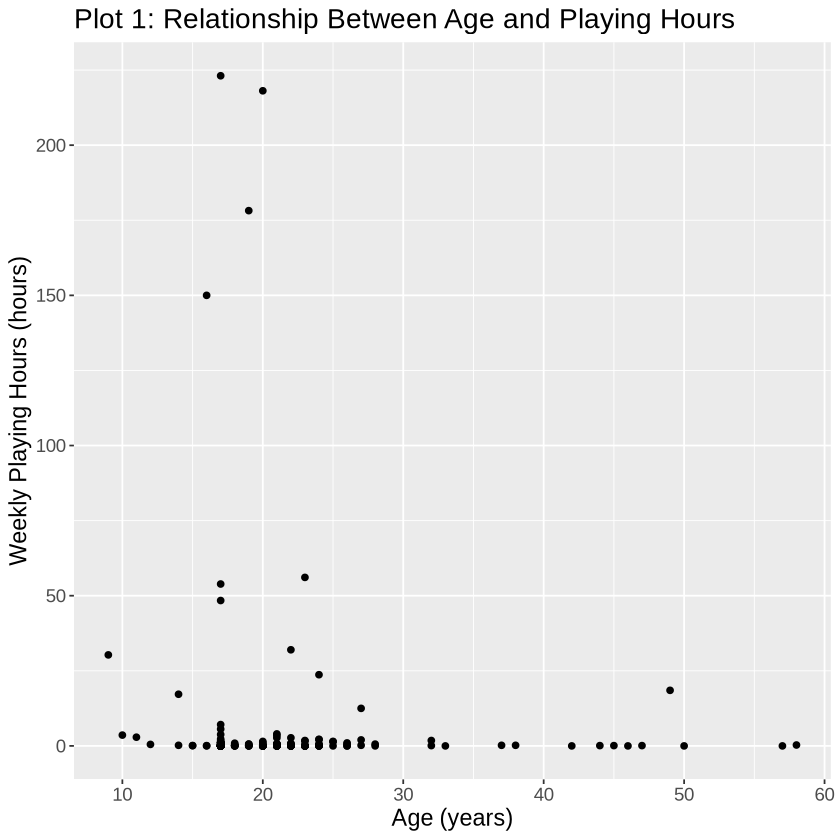

In [77]:
# Visualizing the relationship between age and hours played

ggplot(data = players, aes(x = Age, y = played_hours)) +
    geom_point() +
    labs(
        title = "Plot 1: Relationship Between Age and Playing Hours",
        x = "Age (years)",
        y = "Weekly Playing Hours (hours)",
        ) + 
    theme(text = element_text(size = 14))

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


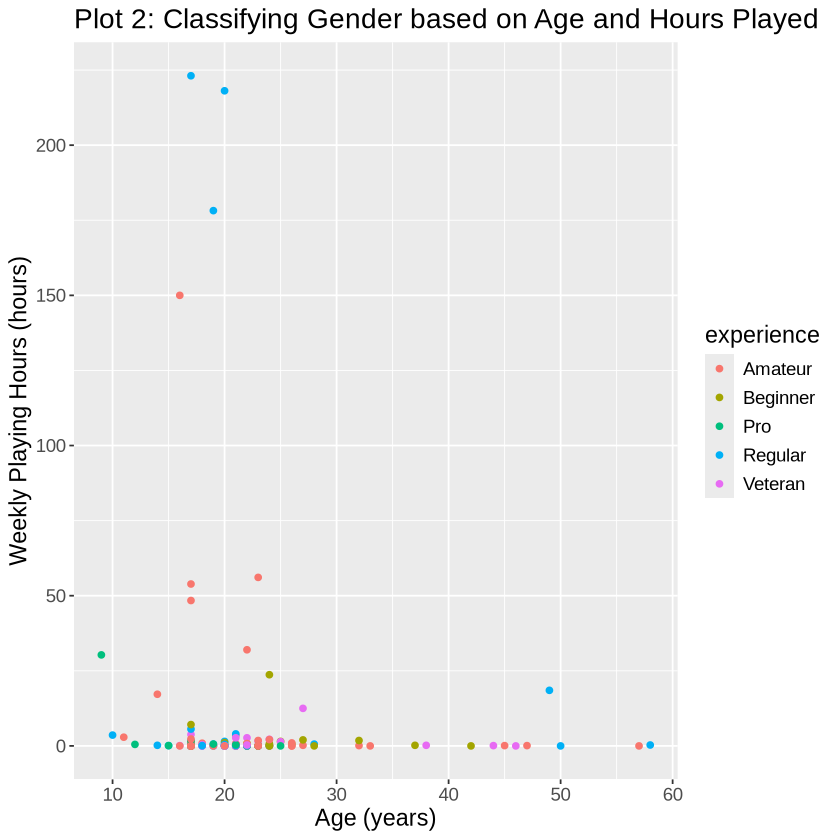

In [78]:
# Seeing if there are clustsers points that indicate experience:

ggplot(data = players, aes(x = Age, y = played_hours, color = experience)) +
    geom_point() +
    labs(
        title = "Plot 2: Classifying Gender based on Age and Hours Played",
        x = "Age (years)",
        y = "Weekly Playing Hours (hours)",
        ) + 
    theme(text = element_text(size = 14))

### Data Analysis 

In [79]:
# Split into training and testing data

set.seed(3456) 

players_split <- initial_split(players, prop = 0.75, strata = experience)  
players_train <- training(players_split)   
players_test <- testing(players_split)

In [80]:
# Pre-process the variables by scaling them in a recipe

players_recipe <- recipe(experience ~ Age + played_hours , data = players_train) |>
   step_center(all_predictors()) |>
   step_scale(all_predictors())
players_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Centering for: all_predictors()

• Scaling for: all_predictors()



In [81]:
# Specifcy model with tuning on the number of neighbours

knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

In [82]:
# Perform a 5-fold cross validation on the training set

fold <- vfold_cv(players_train, v=5, strata = experience)

In [83]:
# Create the workflow analysis to tune the K parameter

k_vals <- tibble(neighbors = seq(from = 2, to = 15, by = 1))

results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_spec) |>
      tune_grid(resamples = fold, grid = k_vals) |>
      collect_metrics()

accuracies <- results |>
            filter(.metric == "accuracy")

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 30 rows.
               ✖ Assigned data has 31 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 31 to size 30.

There were issues with some computations   A: x1

→ B | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 29 rows.
               ✖ Assigned data has 30 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 30 to size 29.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1





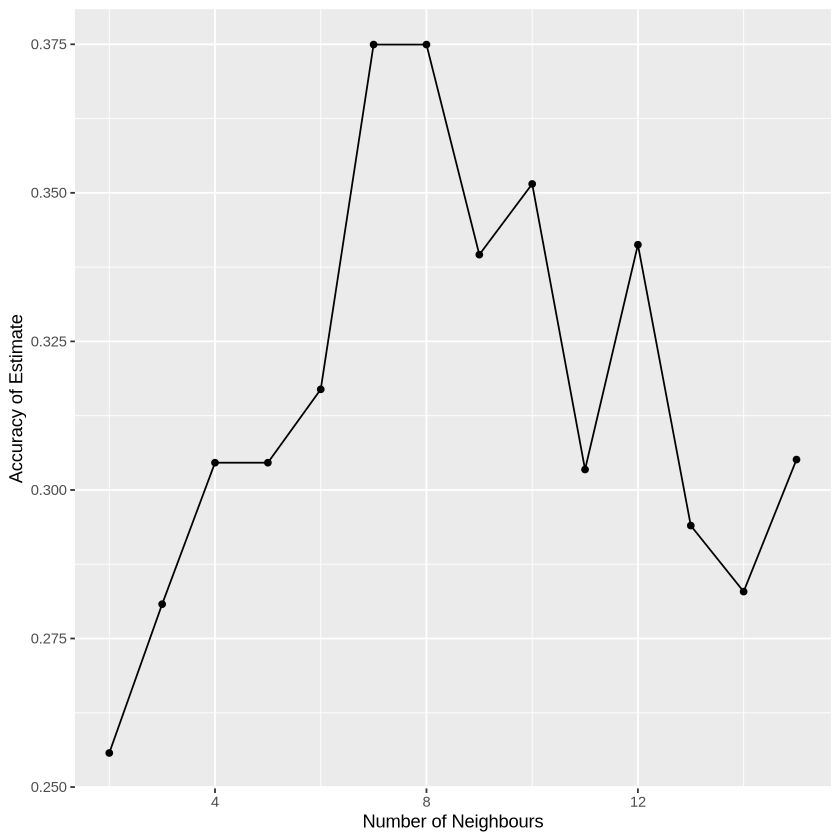

In [84]:
# Plotting the results to find K

cross_val_plot <- accuracies |>
                ggplot(aes(x=neighbors, y=mean)) +
                geom_point() + geom_line() +
                labs(x = "Number of Neighbours", y= "Accuracy of Estimate")
cross_val_plot

In [85]:
# Fitting the final model

players_spec <- nearest_neighbor(weight_func="rectangular", neighbors=8) |>
            set_engine("kknn") |>
            set_mode("classification")

players_fit <- workflow() |>
          add_recipe(players_recipe) |>
          add_model(players_spec) |>
          fit(data = players_train)

In [86]:
# Testing the model on the dataset

players_predictions <- predict(players_fit, players_test) |>
                    bind_cols(players_test)

players_metrics <- players_predictions |>
                metrics(truth = experience, estimate = .pred_class)

players_conf_mat <- players_predictions |>
                conf_mat(truth = experience, estimate = .pred_class)


players_metrics
players_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.22000000
kap,multiclass,-0.07556536


          Truth
Prediction Amateur Beginner Pro Regular Veteran
  Amateur        7        7   3       5       8
  Beginner       1        2   0       0       1
  Pro            1        0   0       0       0
  Regular        1        0   0       0       0
  Veteran        6        1   1       4       2

### Visualization of Analysis

## Discussion

## References